In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from embeddings import get_glove_embedding_matrix, sentence_to_indexes
from emb_path import glove_6B_50d_path, glove_6B_300d_path
from gem import GEM
from scipy.stats import pearsonr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def read_sts(path):
    df = pd.read_csv(path, sep='\n', header=None, names=['row'])
    df = pd.DataFrame(df.row.str.split('\t', 6).tolist(), columns=['', 'genre','filename','year','score','sentence1','sentence2'])
    df.drop(df.columns[[0,1,2,3]], inplace=True, axis=1)
    df["score"] = pd.to_numeric(df["score"])
    return df

In [3]:
sts_train = read_sts('data/sts_benchmark/sts-train.csv')
sts_dev = read_sts('data/sts_benchmark/sts-dev.csv')
sts_test = read_sts('data/sts_benchmark/sts-test.csv')

In [4]:
sts_train.shape, sts_dev.shape, sts_test.shape

((5749, 3), (1500, 3), (1379, 3))

In [5]:
sts_test.head()

,score,sentence1,sentence2
0,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.5,A man is playing a harp.,A man is playing a keyboard.


In [6]:
%%time
e, v = get_glove_embedding_matrix(glove_6B_300d_path)
sentences_inds = []
for sent in sts_test.sentence1.values.tolist():
    sentences_inds.append(sentence_to_indexes(sent, v))
for sent in sts_test.sentence2.values.tolist():
    sentences_inds.append(sentence_to_indexes(sent, v))

CPU times: user 33.9 s, sys: 1.7 s, total: 35.6 s
Wall time: 36.5 s


In [7]:
%%time
gem = GEM(sentences_inds, e)
gem_result, s = gem.get_sentence_embeddings(sigma_power=1)

CPU times: user 1min 2s, sys: 250 ms, total: 1min 3s
Wall time: 31.9 s


In [8]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(gem_result.T)

def pred(ind, sim):
    n1 = sim.shape[0] // 2
    return sim[ind, n1+ind]

sts_test['pred'] = sts_test.apply(lambda row: pred(row.name, sim), axis=1)

CPU times: user 238 ms, sys: 21.2 ms, total: 259 ms
Wall time: 132 ms


In [9]:
sts_test.corr()

,score,pred
score,1.000000,0.651437
pred,0.651437,1.000000


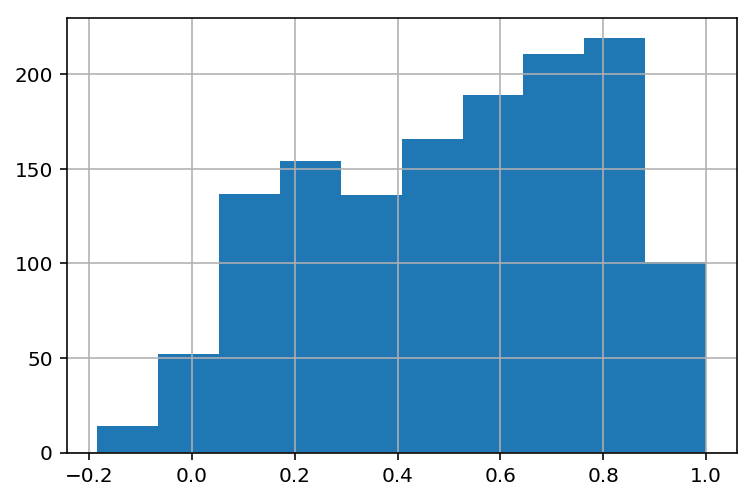

In [10]:
sts_test.pred.hist()

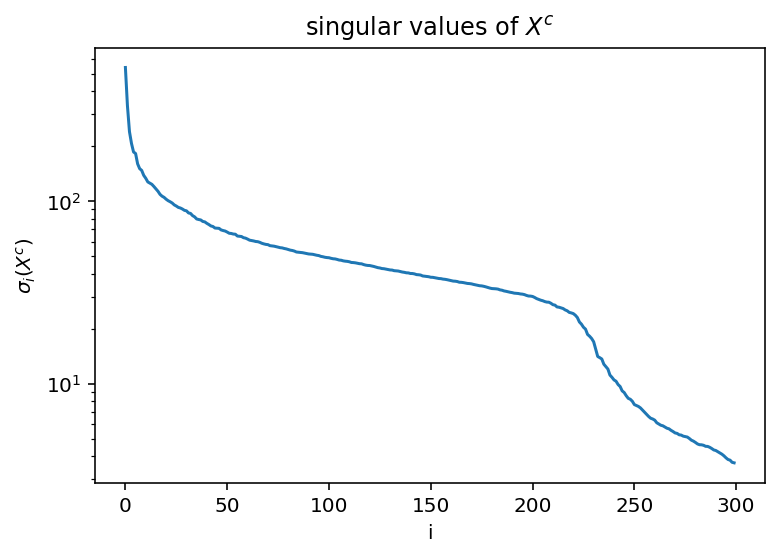

In [11]:
plt.plot(s)
plt.yscale('log')
plt.title(r'singular values of $X^c$')
plt.xlabel('i')
plt.ylabel(r'$\sigma_i(X^c)$')
plt.show()